<a href="https://colab.research.google.com/github/qwenw57/experimentation/blob/master/FinalProject_AB_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
from google.colab import files
from functools import partial
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.special
import statsmodels.formula.api as sfa
import scipy.stats
import statsmodels.stats.power as power
from functools import partial
from progressbar import progressbar

mpl.rcParams['figure.dpi'] = 100
plt.style.use('seaborn-dark')
np.random.seed(94115)

In [ ]:
np.random.seed(94115)

N = 1600

# Each child's family on has an individual level of "econ_status".
# We'll model this charitability as being normally distributed.
econ_status = np.random.normal(loc=0, scale=0.5, size=N)
pro_status= []
label = []
for i in econ_status: 
  if i < -0.34: pro_status.append(0.25), label.append('low')
  if -0.34<i<0.3: pro_status.append(0.5), label.append('medium')
  if i>0.3: pro_status.append(0.75), label.append('high')

ATE = 0.8
Y0 = np.random.lognormal(mean=(econ_status + 0.5), sigma=0.1, size=N)
Y1 = Y0.copy()+ ATE

#pro_econ_status = scipy.special.expit(econ_status)
D = np.random.binomial(n=1, p=pro_status)

# Calculate the *actual* outcome.
Y = Y1 * D + Y0 * (1 - D)

# Put the data together for analysis.
df = pd.DataFrame({
    'D': D,
    'Y0': Y0, 
    'Y1': Y1, 
    'Y': Y,
    'y1-y0': Y1 - Y0,
    'econ_status': econ_status,
    'econ_status_label': label
})

In [ ]:
df

,D,Y0,Y1,Y,y1-y0,econ_status,econ_status_label
0,0,2.229693,3.029693,2.229693,0.8,0.276648,medium
1,0,0.737154,1.537154,0.737154,0.8,-0.724951,low
2,1,2.658408,3.458408,3.458408,0.8,0.501950,high
3,0,1.600921,2.400921,1.600921,0.8,0.029863,medium
4,0,1.222128,2.022128,1.222128,0.8,-0.283706,medium
...,...,...,...,...,...,...,...
1595,1,1.726591,2.526591,2.526591,0.8,0.065007,medium
1596,1,2.061011,2.861011,2.861011,0.8,0.162726,medium
1597,1,2.477428,3.277428,3.277428,0.8,0.326658,high
1598,1,1.553691,2.353691,2.353691,0.8,-0.020610,medium


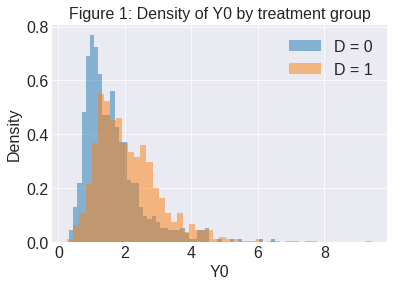

In [ ]:
column_to_plot = 'Y0'
ax = df.query('D==0')[column_to_plot].hist(bins = 50, alpha=0.5, density=True, label='D = 0')
ax = df.query('D==1')[column_to_plot].hist( bins= 50, alpha=0.5, density=True, ax=ax, label='D = 1')
ax.legend(fontsize=16)
ax.set_xlabel(column_to_plot, fontsize=16)
ax.set_ylabel('Density', fontsize=16)
ax.set_title("Figure 1: Density of {} by treatment group".format(column_to_plot), fontsize=16)
ax.tick_params(labelsize=16)


In [ ]:
df['Y'].mean()

# Calculate E[Y0 | D=0]​ Problem Set 1

print("E[Y0|D=0] = {}".format(df.query("D == 0")['Y0'].mean()))

print("E[Y1|D=1] = {}".format(df.query("D == 1")['Y1'].mean()))

print("E[Y1|D=1] - E[Y0|D=0] = {}".format(df.query("D == 1")['Y1'].mean() - df.query("D == 0")['Y0'].mean()))
print("E[Y0|D=1] - E[Y0|D=0] = {}".format(df.query("D == 1")['Y0'].mean() - df.query("D == 0")['Y0'].mean()))

E[Y0|D=0] = 1.6157728102218414
E[Y1|D=1] = 2.932021730108892
E[Y1|D=1] - E[Y0|D=0] = 1.3162489198870508
E[Y0|D=1] - E[Y0|D=0] = 0.5162489198870492


In [ ]:
r = sfa.ols("Y ~ D", df).fit(cov_type='HC1')

print("Estimate of ATE = {:.5f}".format(r.params['D']))
print(r.summary(yname="Conversion"))

Estimate of ATE = 1.31625
                            OLS Regression Results                            
Dep. Variable:             Conversion   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     753.0
Date:                Mon, 19 Oct 2020   Prob (F-statistic):          3.73e-136
Time:                        17:23:54   Log-Likelihood:                -2224.5
No. Observations:                1600   AIC:                             4453.
Df Residuals:                    1598   BIC:                             4464.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6158     

In [ ]:
r = sfa.ols("Y ~ D + C(econ_status_label)", df).fit(cov_type='HC1')

print("Estimate of ATE = {:.5f}".format(r.params['D']))
print(r.summary(yname="Conversion"))

Estimate of ATE = 0.78391
                            OLS Regression Results                            
Dep. Variable:             Conversion   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     1968.
Date:                Mon, 19 Oct 2020   Prob (F-statistic):               0.00
Time:                        17:23:57   Log-Likelihood:                -1404.7
No. Observations:                1600   AIC:                             2817.
Df Residuals:                    1596   BIC:                             2839.
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------

In [ ]:
def diff(N = 1600, ATE = 0.8):
  params = locals().copy()

  # Each child's family on has an individual level of "econ_status".
  # We'll model this charitability as being normally distributed.
  econ_status = np.random.normal(loc=0, scale=0.5, size=N)
  pro_status= []
  label = []
  for i in econ_status: 
    if i < -0.34: pro_status.append(0.25), label.append('low')
    if -0.34<i<0.3: pro_status.append(0.5), label.append('medium')
    if i>0.3: pro_status.append(0.75), label.append('high')

  ATE = 0.8
  Y0 = np.random.lognormal(mean=(econ_status + 0.5), sigma=0.1, size=N)
  Y1 = Y0.copy()+ ATE

  #pro_econ_status = scipy.special.expit(econ_status)
  D = np.random.binomial(n=1, p= 0.5)

  # Calculate the *actual* outcome.
  Y = Y1 * D + Y0 * (1 - D)

  # Put the data together for analysis.
  df = pd.DataFrame({
      'D': D,
      'Y0': Y0, 
      'Y1': Y1, 
      'Y': Y,
      'y1-y0': Y1 - Y0,
      'econ_status': econ_status,
      'econ_status_label': label
  })


  r = sfa.ols("Y ~ D + C(econ_status_label)", df).fit(cov_type='HC1')
  diffs = {
      'difference': r.params['D'],
      'se': r.bse['D'] ,
      'p': r.pvalues['D'],
      'nate' :df.query("D == 1")['Y1'].mean() - df.query("D == 0")['Y0'].mean(),
      'sb' : df.query("D == 1")['Y0'].mean() - df.query("D == 0")['Y0'].mean(),
  }
  diffs.update(params)
  return diffs

In [ ]:
checks = pd.DataFrame([diff(N=N) for _ in np.arange(0, 10) for N in np.arange(100, 10000, 100)])

In [ ]:
checks

,difference,se,p,nate,sb,ATE,N
0,1.975374e+00,9.715011e-02,6.538172e-92,NaN,NaN,0.8,100
1,1.892103e+00,5.789472e-02,2.833411e-234,NaN,NaN,0.8,200
2,0.000000e+00,0.000000e+00,NaN,NaN,NaN,0.8,300
3,0.000000e+00,0.000000e+00,NaN,NaN,NaN,0.8,400
4,2.027440e+00,5.671095e-02,6.519261e-280,NaN,NaN,0.8,500
...,...,...,...,...,...,...,...
985,0.000000e+00,0.000000e+00,NaN,NaN,NaN,0.8,9500
986,-7.596558e+11,7.866334e+11,3.341919e-01,NaN,NaN,0.8,9600
987,1.983415e+00,9.824626e-03,0.000000e+00,NaN,NaN,0.8,9700
988,0.000000e+00,0.000000e+00,NaN,NaN,NaN,0.8,9800


In [ ]:
checks.groupby('N')['difference'].mean()

N
100     1.380343e+00
200     1.172550e+00
300     5.794439e-01
400     1.016864e+00
500     9.853493e-01
            ...     
9500    1.320610e+11
9600   -2.729181e+11
9700    1.184847e+00
9800    4.098847e+11
9900    2.467433e+11
Name: difference, Length: 99, dtype: float64

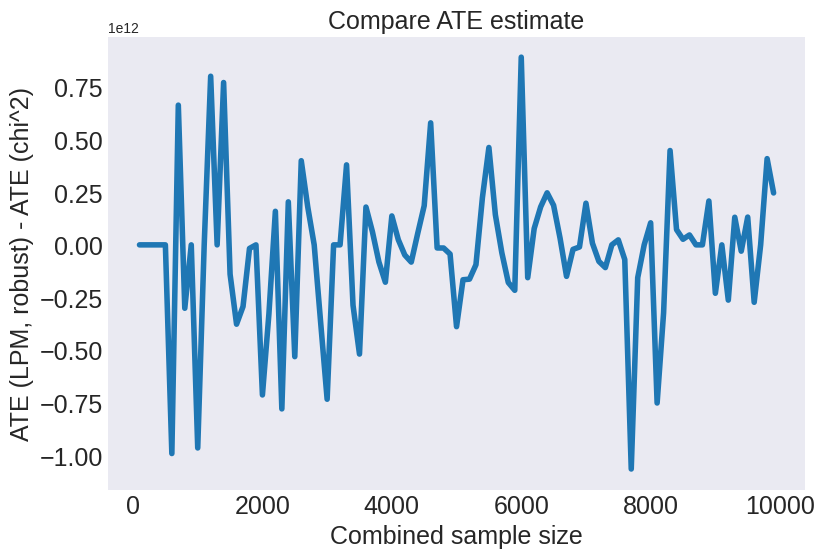

In [ ]:
ax = checks.groupby('N')['difference'].mean().plot(figsize=(9,6), linewidth=4)
ax.set_ylabel("ATE (LPM, robust) - ATE (chi^2)", fontsize=18)
ax.set_xlabel("Combined sample size", fontsize=18)
ax.set_title("Compare ATE estimate", fontsize=18)
ax.tick_params(labelsize=18)

Rejection rate from power calculator =  0.35926368917297585


In [ ]:
def draw_one_sample_two_groups(ATE, mu, sigma, n, share_treatment):
  
    units = np.arange(0, n)
    treatment_units = np.random.choice(units, int(len(units) * share_treatment), replace=False)
    df = pd.DataFrame({'i': units})

    df['d'] = df['i'].isin(treatment_units).astype('float')
   
    Yi = np.random.normal(loc=mu + ATE * df['d'], scale=sigma, size=n)
    df['y'] = Yi
    return df

  
def get_difference_in_means(df):

    means = df.groupby('d')['y'].mean()
    diff = means.loc[1] - means.loc[0]

    N = df.shape[0]
    N_treatment = df['d'].sum()
    
    return {
        'N': N,
        'N_treatment': N_treatment,
        'mean_treatment': means.loc[1],
        'mean_control': means.loc[0],
        'diff': diff
    }

In [ ]:
mu = 0.5
sigma = 1

b = 500  # Total number of *samples* to generate
n = 1000  # The number of data points in each sample

share_treatment = 0.5

ATE = 0.8
list_of_samples = [draw_one_sample_two_groups(ATE=ATE, mu=mu, sigma=sigma, n=n, share_treatment=share_treatment) for _ in progressbar(range(0, b))]
sample_results = pd.DataFrame([get_difference_in_means(sample) for sample in progressbar(list_of_samples)])

assert((sample_results['N'] == n).all())
assert((sample_results['N_treatment'] == int(n * share_treatment)).all())

100% (500 of 500) |######################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (500 of 500) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


No handles with labels found to put in legend.


count    500.000000
mean       0.801208
std        0.061976
min        0.612990
25%        0.756260
50%        0.799293
75%        0.847702
max        0.960656
Name: diff, dtype: float64


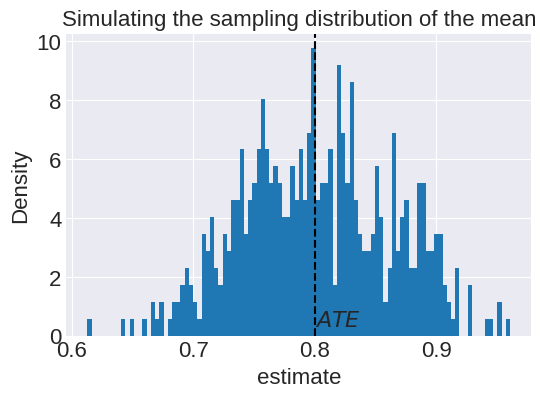

In [ ]:
ax = sample_results['diff'].hist(bins=100, density=True)

# Normal PDF assuming equally-sized treatment and control groups
normal_pdf = partial(scipy.stats.norm.pdf, loc=0.3, scale=(sigma * np.sqrt((2/n) + 2/n)))
grid_of_x_values = np.arange(-0.05, 1.0, 0.02)
pdf = pd.DataFrame({'x': grid_of_x_values})
pdf['fx'] = pdf['x'].apply(normal_pdf)
# pdf.plot(x='x', y='fx', ax=ax, linewidth=2, alpha=0.85, color='black', label=r'Theoretical density: 50/50 split')


# Add a vertical marker line and labels
# This time we will graph the mean of the probability distribution.
ax.axvline(ATE, color='black', linestyle='--')
ax.text(x=ATE, y=pdf['fx'].max()*0.05, s=r'$ATE$', fontsize=16)
ax.set_xlabel('estimate', fontsize=16)
ax.set_ylabel('Density', fontsize=16)
ax.set_title("Simulating the sampling distribution of the mean", fontsize=16)
ax.legend(fontsize=10)
ax.tick_params(labelsize=16)

print(sample_results['diff'].describe())

In [ ]:
def get_ttest_analysis(df):    
    # A slower way to do this:
    treatment_group =  (df['d'] == 1)
    #diff = df.loc[treatment_group, 'y'].mean() - df.loc[~treatment_group, 'y'].mean()
    results = scipy.stats.ttest_ind(
        df.loc[treatment_group, 'y'], 
        df.loc[~treatment_group, 'y'])
    return {'t': results.statistic, 'p': results.pvalue}

def get_difference_in_means_with_ttest(df, alpha):
    # Calculate means by each group. Then take the difference and do a t-test.
    means = df.groupby('d')['y'].mean()
    diff = means.loc[1] - means.loc[0]

    N = df.shape[0]
    N_treatment = df['d'].sum()
    ttest_results = get_ttest_analysis(df)
    reject_null = (ttest_results['p'] < alpha).astype('float')
    
    return {
        'N': N,
        'N_treatment': N_treatment,
        'mean_treatment': means.loc[1],
        'mean_control': means.loc[0],
        'diff': diff,
        't': ttest_results['t'],
        'p': ttest_results['p'],
        'reject_null': reject_null
    }

def get_simulation_results(expectation_Y0, ATE, share_treatment, n, B, sigma, alpha):
  params = dict(ATE=ATE, mu=expectation_Y0, n=n, share_treatment=share_treatment, sigma=sigma)
  list_of_samples = [draw_one_sample_two_groups(**params) for _ in progressbar(range(0, B))]
  simulations = pd.DataFrame([get_difference_in_means_with_ttest(sample, alpha) for sample in progressbar(list_of_samples)])
  
  # Return a summary of the simulations and the specified paramters.
  return {
      'diff_mean': simulations['diff'].mean(),
      'diff_std': simulations['diff'].std(),
      't_mean': simulations['t'].mean(),
      't_std': simulations['t'].std(),
      'alpha': alpha,
      'p_reject': simulations['reject_null'].mean(),
      'B': B,
      'N': simulations['N'].mean(),
      'N_treatment': simulations['N_treatment'].mean(),
      'share_treatment': share_treatment,
      'expectation_Y0': expectation_Y0,
      'sigma': sigma,
      'ATE': ATE
  }

In [ ]:
B = 500
ATE = 0.0
parameter_grid = [
    dict(B = B, n = 100, expectation_Y0 = 0.5, ATE = ATE, share_treatment = 0.20, sigma = 1, alpha = 0.05),
    dict(B = B, n = 100, expectation_Y0 = 0.5, ATE = ATE, share_treatment = 0.50, sigma = 1, alpha = 0.05),
]

simulation_results =  pd.DataFrame([get_simulation_results(**params) for params in parameter_grid])

# We can also test that the simulations worked as expected.
# For example:
assert((simulation_results['share_treatment'] == simulation_results.eval("N_treatment / N")).all())

100% (500 of 500) |######################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (500 of 500) |######################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (500 of 500) |######################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (500 of 500) |######################| Elapsed Time: 0:00:01 Time:  0:00:01


In [ ]:
simulation_results

,diff_mean,diff_std,t_mean,t_std,alpha,p_reject,B,N,N_treatment,share_treatment,expectation_Y0,sigma,ATE
0,-0.017185,0.245712,-0.068882,0.997174,0.05,0.056,500,100.0,20.0,0.2,0.5,1,0.0
1,-0.010480,0.200923,-0.049364,1.009630,0.05,0.048,500,100.0,50.0,0.5,0.5,1,0.0


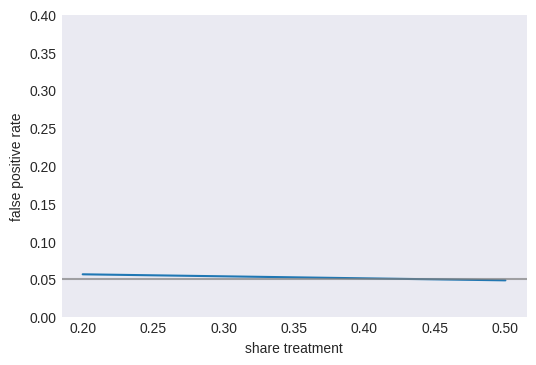

In [ ]:
ax = simulation_results.groupby('share_treatment')['p_reject'].mean().plot()
ax.set_xlabel("share treatment")
ax.set_ylabel("false positive rate")
ax.set_ylim(0, 0.4)
ax.axhline(0.05, color='grey', alpha=0.7)

In [ ]:
def get_ttest_analysis(df):    
    # A slower way to do this:
    treatment_group =  (df['d'] == 1)
    #diff = df.loc[treatment_group, 'y'].mean() - df.loc[~treatment_group, 'y'].mean()
    results = scipy.stats.ttest_ind(
        df.loc[treatment_group, 'y'], 
        df.loc[~treatment_group, 'y'])
    return {'t': results.statistic, 'p': results.pvalue}

def get_difference_in_means_with_ttest(df, alpha):
    # Calculate means by each group. Then take the difference and do a t-test.
    means = df.groupby('d')['y'].mean()
    diff = means.loc[1] - means.loc[0]

    N = df.shape[0]
    N_treatment = df['d'].sum()
    ttest_results = get_ttest_analysis(df)
    reject_null = (ttest_results['p'] < alpha).astype('float')
    
    return {
        'N': N,
        'N_treatment': N_treatment,
        'mean_treatment': means.loc[1],
        'mean_control': means.loc[0],
        'diff': diff,
        't': ttest_results['t'],
        'p': ttest_results['p'],
        'reject_null': reject_null
    }

def get_simulation_results(expectation_Y0, ATE, share_treatment, n, B, sigma, alpha):
  params = dict(ATE=ATE, mu=expectation_Y0, n=n, share_treatment=share_treatment, sigma=sigma)
  list_of_samples = [draw_one_sample_two_groups(**params) for _ in progressbar(range(0, B))]
  simulations = pd.DataFrame([get_difference_in_means_with_ttest(sample, alpha) for sample in progressbar(list_of_samples)])
  
  # Return a summary of the simulations and the specified paramters.
  return {
      'diff_mean': simulations['diff'].mean(),
      'diff_std': simulations['diff'].std(),
      't_mean': simulations['t'].mean(),
      't_std': simulations['t'].std(),
      'alpha': alpha,
      'p_reject': simulations['reject_null'].mean(),
      'B': B,
      'N': simulations['N'].mean(),
      'N_treatment': simulations['N_treatment'].mean(),
      'share_treatment': share_treatment,
      'expectation_Y0': expectation_Y0,
      'sigma': sigma,
      'ATE': ATE
  }

In [ ]:
B = 500
ATE = 0.3
parameter_grid = [
    dict(B = B, n = 100, expectation_Y0 = 0.5, ATE = ATE, share_treatment = 0.20, sigma = 1, alpha = 0.05),
    dict(B = B, n = 500, expectation_Y0 = 0.5, ATE = ATE, share_treatment = 0.20, sigma = 1, alpha = 0.05),
    dict(B = B, n = 1000, expectation_Y0 = 0.5, ATE = ATE, share_treatment = 0.20, sigma = 1, alpha = 0.05),
]

simulation_results =  pd.DataFrame([get_simulation_results(**params) for params in parameter_grid])

# We can also test that the simulations worked as expected.
# For example:
assert((simulation_results['share_treatment'] == simulation_results.eval("N_treatment / N")).all())

100% (500 of 500) |######################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (500 of 500) |######################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (500 of 500) |######################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (500 of 500) |######################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (500 of 500) |######################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (500 of 500) |######################| Elapsed Time: 0:00:01 Time:  0:00:01


In [ ]:
ts02 = simulation_results

In [ ]:
B = 500
ATE = 0.3
parameter_grid = [
    dict(B = B, n = 100, expectation_Y0 = 0.5, ATE = ATE, share_treatment = 0.50, sigma = 1, alpha = 0.05),
    dict(B = B, n = 500, expectation_Y0 = 0.5, ATE = ATE, share_treatment = 0.50, sigma = 1, alpha = 0.05),
    dict(B = B, n = 1000, expectation_Y0 = 0.5, ATE = ATE, share_treatment = 0.50, sigma = 1, alpha = 0.05),
]

simulation_results =  pd.DataFrame([get_simulation_results(**params) for params in parameter_grid])

# We can also test that the simulations worked as expected.
# For example:
assert((simulation_results['share_treatment'] == simulation_results.eval("N_treatment / N")).all())

100% (500 of 500) |######################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (500 of 500) |######################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (500 of 500) |######################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (500 of 500) |######################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (500 of 500) |######################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (500 of 500) |######################| Elapsed Time: 0:00:01 Time:  0:00:01


In [ ]:
ts05 = simulation_results

In [ ]:
ts02

,diff_mean,diff_std,t_mean,t_std,alpha,p_reject,B,N,N_treatment,share_treatment,expectation_Y0,sigma,ATE
0,0.295173,0.248321,1.177067,0.988166,0.05,0.224,500,100.0,20.0,0.2,0.5,1,0.3
1,0.305356,0.110763,2.740153,1.004796,0.05,0.774,500,500.0,100.0,0.2,0.5,1,0.3
2,0.306107,0.075509,3.882549,0.967261,0.05,0.978,500,1000.0,200.0,0.2,0.5,1,0.3


In [ ]:
ts05

,diff_mean,diff_std,t_mean,t_std,alpha,p_reject,B,N,N_treatment,share_treatment,expectation_Y0,sigma,ATE
0,0.306980,0.195423,1.546582,0.984097,0.05,0.348,500,100.0,50.0,0.5,0.5,1,0.3
1,0.299047,0.086878,3.349471,0.980499,0.05,0.934,500,500.0,250.0,0.5,0.5,1,0.3
2,0.304737,0.065517,4.822116,1.040998,0.05,0.998,500,1000.0,500.0,0.5,0.5,1,0.3


In [ ]:
ts05.iloc[:,[5,8]]

,p_reject,N_treatment
0,0.348,50.0
1,0.934,250.0
2,0.998,500.0


Text(700, 0.8, 'share_treatment = 0.2')

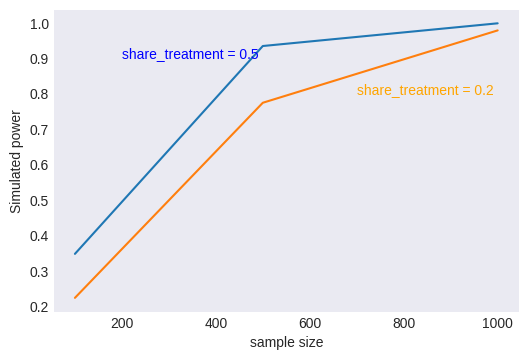

In [ ]:
ax = ts05.groupby('N')['p_reject'].mean().plot()
ax = ts02.groupby('N')['p_reject'].mean().plot()
ax.set_xlabel("sample size")
ax.set_ylabel("Simulated power")
style05 = dict(size=10, color='blue')
style02 = dict(size=10, color='orange')
ax.text(200, 0.9, "share_treatment = 0.5", **style05)
ax.text(700, 0.8, "share_treatment = 0.2", **style02)

In [ ]:
calculated_power = power.tt_ind_solve_power(
    effect_size= 0.3/ 1,
    alpha=0.05,
    nobs1= 500/2,
    ratio= 50/50,
)

# Compare these two!
print("Rejection rate from power calculator when treatment share is 50/50= ", calculated_power)

Rejection rate from power calculator when treatment share is 50/50=  0.9173801660338057


In [ ]:
calculated_power = power.tt_ind_solve_power(
    effect_size= 0.3/ 1,
    alpha=0.05,
    nobs1= 400,
    ratio= 20/80,
)

# Compare these two!
print("Rejection rate from power calculator when treatment share is 20/80= ", calculated_power)

Rejection rate from power calculator when treatment share is 20/80=  0.7636661636652091


In [ ]:
calculated_power = power.tt_ind_solve_power(
    effect_size= 0.8/ 1,
    alpha=0.05,
    nobs1= 54/2,
    ratio= 50/50,
)

# Compare these two!
print("When N= 52, alpha = 0.05, power= ", calculated_power)

When N= 360, alpha = 0.05, power=  0.8224488409647742


In [ ]:
np.random.seed(94115)

N = 1600

# Each child's family on has an individual level of "econ_status".
# We'll model this charitability as being normally distributed.
econ_status = np.random.normal(loc=0, scale=0.5, size=N)
pro_status= []
label = []
for i in econ_status: 
  if i < -0.34: pro_status.append(0.25), label.append('low')
  if -0.34<i<0.3: pro_status.append(0.5), label.append('medium')
  if i>0.3: pro_status.append(0.75), label.append('high')

ATE = 0.0
Y0 = np.random.lognormal(mean=(econ_status + 0.5), sigma=0.1, size=N)
Y1 = Y0.copy()+ ATE

#pro_econ_status = scipy.special.expit(econ_status)
D = np.random.binomial(n=1, p=pro_status)

# Calculate the *actual* outcome.
Y = Y1 * D + Y0 * (1 - D)

# Put the data together for analysis.
df = pd.DataFrame({
    'D': D,
    'Y0': Y0, 
    'Y1': Y1, 
    'Y': Y,
    'y1-y0': Y1 - Y0,
    'econ_status': econ_status,
    'econ_status_label': label
})

In [ ]:
r = sfa.ols("Y ~ D + C(econ_status_label)", df).fit(cov_type='HC1')

print("Estimate of ATE = {:.5f}".format(r.params['D']))
print(r.summary(yname="Conversion"))

Estimate of ATE = -0.01609
                            OLS Regression Results                            
Dep. Variable:             Conversion   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     1176.
Date:                Mon, 19 Oct 2020   Prob (F-statistic):               0.00
Time:                        21:31:56   Log-Likelihood:                -1404.7
No. Observations:                1600   AIC:                             2817.
Df Residuals:                    1596   BIC:                             2839.
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------